# 📊 Sales Analysis and Forecasting using Machine Learning

This notebook performs an end-to-end sales analysis and forecasting task using Python.

It covers:
- Generating or loading sales data
- Data visualization
- Feature engineering (lags, cyclical features)
- Machine Learning forecasting models
- Model comparison (RMSE, MAE)

Let's begin 👇


In [1]:

# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit

# 1️⃣ Generate synthetic monthly sales data (2018-01 to 2022-12)
rng = pd.date_range(start="2018-01-01", end="2022-12-01", freq="MS")
np.random.seed(42)

trend = np.linspace(100, 500, len(rng))
seasonal = 50 * np.sin(2 * np.pi * (rng.month - 1) / 12)
noise = np.random.normal(scale=30, size=len(rng))
promotion = 20 * ((rng.month == 11) | (rng.month == 12)).astype(int)

sales = trend + seasonal + promotion + noise

df = pd.DataFrame({
    "date": rng,
    "year": rng.year,
    "month": rng.month,
    "sales": np.round(sales, 2)
})

df.to_csv("sales_data.csv", index=False)
df.head()


,date,year,month,sales
0,2018-01-01,2018,1,114.90
1,2018-02-01,2018,2,127.63
2,2018-03-01,2018,3,176.29
3,2018-04-01,2018,4,216.03
4,2018-05-01,2018,5,163.40


## 📈 Visualize the Data

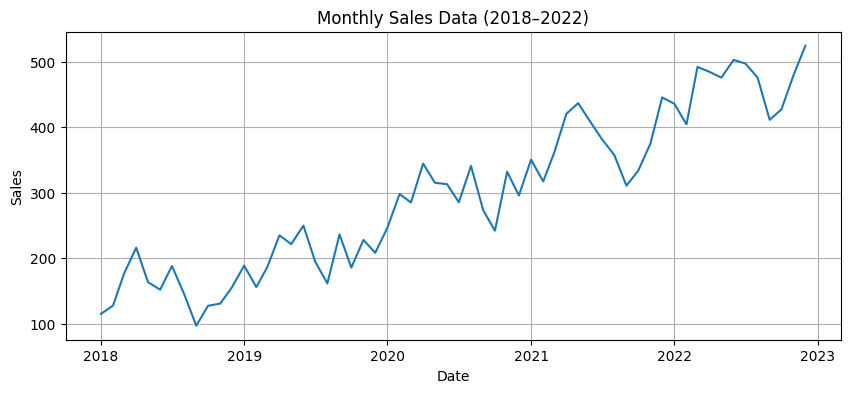

In [2]:

plt.figure(figsize=(10,4))
plt.plot(df['date'], df['sales'])
plt.title("Monthly Sales Data (2018–2022)")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.grid(True)
plt.show()


## 🧮 Feature Engineering

In [3]:

def create_lag_features(df, lags=12):
    df2 = df.copy().set_index("date")
    for lag in range(1, lags+1):
        df2[f"lag_{lag}"] = df2["sales"].shift(lag)
    df2["month_sin"] = np.sin(2 * np.pi * (df2["month"]-1) / 12)
    df2["month_cos"] = np.cos(2 * np.pi * (df2["month"]-1) / 12)
    df2["trend"] = np.arange(len(df2))
    return df2.dropna().reset_index()

df_feat = create_lag_features(df, lags=12)
df_feat.head()


,date,year,month,sales,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,month_sin,month_cos,trend
0,2019-01-01,2019,1,188.61,155.60,130.59,127.29,96.85,145.48,188.05,151.87,163.40,216.03,176.29,127.63,114.90,0.000000,1.000000e+00,12
1,2019-02-01,2019,2,155.74,188.61,155.60,130.59,127.29,96.85,145.48,188.05,151.87,163.40,216.03,176.29,127.63,0.500000,8.660254e-01,13
2,2019-03-01,2019,3,186.47,155.74,188.61,155.60,130.59,127.29,96.85,145.48,188.05,151.87,163.40,216.03,176.29,0.866025,5.000000e-01,14
3,2019-04-01,2019,4,234.83,186.47,155.74,188.61,155.60,130.59,127.29,96.85,145.48,188.05,151.87,163.40,216.03,1.000000,6.123234e-17,15
4,2019-05-01,2019,5,221.39,234.83,186.47,155.74,188.61,155.60,130.59,127.29,96.85,145.48,188.05,151.87,163.40,0.866025,-5.000000e-01,16


## 🔀 Train-Test Split

In [4]:

train = df_feat[df_feat["date"] < "2022-01-01"]
test = df_feat[df_feat["date"] >= "2022-01-01"]

feature_cols = [c for c in df_feat.columns if c.startswith("lag_")] + ["month_sin", "month_cos", "trend"]
X_train, y_train = train[feature_cols], train["sales"]
X_test, y_test = test[feature_cols], test["sales"]

X_train.shape, X_test.shape


((36, 15), (12, 15))

## 🤖 Train ML Models

In [6]:

models = {
    "LinearRegression": LinearRegression(),
    "RandomForest": RandomForestRegressor(n_estimators=200, random_state=42),
    "GradientBoosting": GradientBoostingRegressor(n_estimators=200, random_state=42)
}

results = []
predictions = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    predictions[name] = pred
    mse= mean_squared_error(y_test, pred) #return mse
    rmse=np.sqrt(mse) #convert to rmse
    mae = mean_absolute_error(y_test, pred)
    results.append({"model": name, "RMSE": rmse, "MAE": mae})

results_df = pd.DataFrame(results).sort_values("RMSE")
results_df


,model,RMSE,MAE
0,LinearRegression,39.881469,35.696607
2,GradientBoosting,74.056453,63.560088
1,RandomForest,75.244312,65.117275


## 📊 Compare Predictions

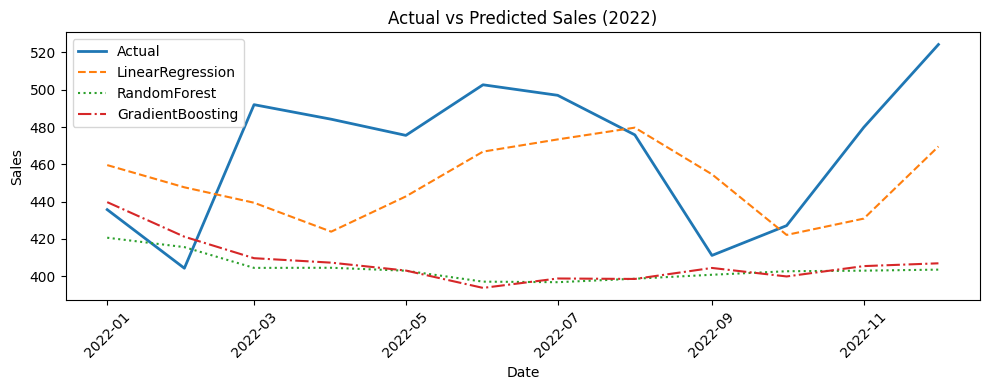

In [7]:

pred_df = test[["date","sales"]].copy().reset_index(drop=True)
for name, pred in predictions.items():
    pred_df[f"pred_{name}"] = np.round(pred, 2)

plt.figure(figsize=(10,4))
plt.plot(pred_df["date"], pred_df["sales"], label="Actual", linewidth=2)
plt.plot(pred_df["date"], pred_df["pred_LinearRegression"], label="LinearRegression", linestyle="--")
plt.plot(pred_df["date"], pred_df["pred_RandomForest"], label="RandomForest", linestyle=":")
plt.plot(pred_df["date"], pred_df["pred_GradientBoosting"], label="GradientBoosting", linestyle="-.")
plt.title("Actual vs Predicted Sales (2022)")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## 🏁 Conclusion

In [8]:

best_model = results_df.loc[results_df['RMSE'].idxmin(), 'model']
print(f"The best-performing model is: {best_model}")


The best-performing model is: LinearRegression
